# Bi-Directional LSTM for classifying MNIST digits
***

## Written in TensorFlow

In [7]:
from __future__ import print_function
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf
import math
import pickle as p
import tensorflow as tf
import numpy as np
import utils
import json
import IPython


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## MNIST Dataset Sample

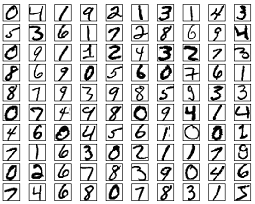

In [2]:
#Defining some parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Each image is 28x28 pixels, hence the following training parameters
num_input = 28
timesteps = 28
num_hidden = 128
num_classes = 10

X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [3]:
weights = {
    'out': tf.Variable(tf.random_normal([2*num_hidden, num_classes]))
}

biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

## Bi-Directional RNN, output = Wx + b

In [4]:
def BiRNN(x, weights, biases):
    x = tf.unstack(x, timesteps, 1)
    
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x, dtype=tf.float32)
    except:
        outputs = rnn.stack_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

## Softmax normalization, defining loss, accuracy and initializing variables

In [5]:
logits = BiRNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Cross entropy function to measure loss
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y))

# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Prediction is correct if softmax output equals the label of the image
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y,1))

#Accuracy is the ratio of all correct predictions over the sample set
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

## Run session, train samples on a batch size, iterate over 10000 times

In [32]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        
        sess.run(train_op, feed_dict = {X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            
            loss, acc = sess.run([loss_op, accuracy], feed_dict = {X: batch_x, Y: batch_y})
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

            

    print("Optimization finished")
    
    
    # Test on a sample of 128 images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

Step 1, Minibatch Loss= 2.9048, Training Accuracy= 0.102
Step 200, Minibatch Loss= 2.0684, Training Accuracy= 0.281
Step 400, Minibatch Loss= 1.8758, Training Accuracy= 0.414
Step 600, Minibatch Loss= 1.7777, Training Accuracy= 0.453
Step 800, Minibatch Loss= 1.6035, Training Accuracy= 0.500
Step 1000, Minibatch Loss= 1.5756, Training Accuracy= 0.508
Step 1200, Minibatch Loss= 1.5595, Training Accuracy= 0.500
Step 1400, Minibatch Loss= 1.4953, Training Accuracy= 0.492
Step 1600, Minibatch Loss= 1.3456, Training Accuracy= 0.547
Step 1800, Minibatch Loss= 1.2873, Training Accuracy= 0.547
Step 2000, Minibatch Loss= 1.3607, Training Accuracy= 0.500
Step 2200, Minibatch Loss= 1.2287, Training Accuracy= 0.562
Step 2400, Minibatch Loss= 1.0749, Training Accuracy= 0.680
Step 2600, Minibatch Loss= 1.1633, Training Accuracy= 0.633
Step 2800, Minibatch Loss= 1.1191, Training Accuracy= 0.633
Step 3000, Minibatch Loss= 1.0413, Training Accuracy= 0.688
Step 3200, Minibatch Loss= 1.0673, Training Acc

## Final accuracy on a test set is 89.0625%